# Search Algorithm Integration

In this tutorial we show how to integrate a search algorithm into OpenSBT to use it for testing.
To integrate a search algorithm we need to create a new class subclassing the [`Optimizer`](https://git.fortiss.org/opensbt/opensbt-core/-/blob/main/algorithm/optimizer.py) class. There are different options available depending on whether the algorithm exists in pymoo already or not. We show in the following in detail for each of the cases how the integration is done.


## Algorithm exists in Pymoo

If the search algorithm exists in `pymoo`, we can instantiate it in the `__init__` method and assign it to the `algorithm` variable. Existing algorithms in pymoo can be explored [here](https://pymoo.org/algorithms/index.html).

In this example we want to integrate the Non-dominated Sorting Genetic Algorithm (NSGA-II) algorithm wich already exists in [pymoo](https://github.com/anyoptimization/pymoo/blob/main/pymoo/algorithms/moo/nsga2.py#L84) into OpenSBT. 

The final NSGA-II related Optimizer class looks as follows:

```python
from pymoo.core.problem import Problem
from pymoo.termination import get_termination
from pymoo.algorithms.moo.nsga2 import NSGA2
from algorithm.optimizer import Optimizer
from experiment.search_configuration import SearchConfiguration

class Nsga2Optimizer(Optimizer):

    # This name is used in the output plots 
    algorithm_name = "NSGA-II"

    def __init__(self,
                problem: Problem,
                config: SearchConfiguration):

        # Default code
        self.config = config
        self.problem = problem
        self.res = None

        # The parameters dict is forwarded to the output and is algorithm specific;
        # It contains information about the algorithm configuration
        self.parameters = {
            "Population size" : str(config.population_size),
            "Max number of generations" : str(config.n_generations),
        }

        # Initialize pymoo algorithm
        self.algorithm = NSGA2(
            pop_size=config.population_size,
        )

        ''' Prioritize max search time over set maximal number of generations'''
        if config.maximal_execution_time is not None:
            self.termination = get_termination("time", config.maximal_execution_time)
        else:
            self.termination = get_termination("n_gen", config.n_generations)

        self.save_history = True
```


## Algorithm does not exist in Pymoo

If the algorithm does not exist in pymoo, we can override `run` and implement the algorithm into the run method. The type of the returned object should be a `SimulationResult`. As an example, we have implemented the machine learning- based algorithm NSGA-II-DT algorithm from [Abdessalam et al.](https://ieeexplore.ieee.org/document/8453180) which does not exist in Pymoo.

**Note: A more convenient way to integrate a individualized algorithm is by sublassing the [`Algorithm`](https://github.com/anyoptimization/pymoo/blob/main/pymoo/core/algorithm.py) class from pymoo and using the first option for the integration.** 

We see below an excerpt of the implementation of NSGAII-DT where we have performed the steps without creating a new `Algorithm` class. We have ommited algorithm specific dependencies. The complete implementation is available [here](https://git.fortiss.org/opensbt/opensbt-core/-/blob/main/algorithm/nsga2_optimizer.py).

Note that the implementation of the algorithm functionality starts from 104ff. 

```python
from pymoo.core.problem import Problem
from pymoo.termination import get_termination
from algorithm.optimizer import Optimizer
from experiment.search_configuration import SearchConfiguration

class NsgaIIDTOptimizer(Optimizer):

    algorithm_name = "NSGAII-DT"
    
    def __init__(self,
                 problem: Problem,
                 config: SearchConfiguration):

        self.problem = problem
        self.config = config
        self.res = None

        self.parameters = {
            'Number of maximal tree generations': str(config.max_tree_iterations),
            "Population size": str(config.population_size),
            "Number of generations": str(config.inner_num_gen),
            "Number of offsprings": str(config.num_offsprings),
            "Crossover probability": str(config.prob_crossover),
            "Crossover eta": str(config.eta_crossover),
            "Mutation probability": str(config.prob_mutation),
            "Mutation eta": str(config.eta_mutation)
        }
        
    ''' Overriding run of optimizer class to implement specific search approach'''
    def run(self) -> SimulationResult:
        
        ''' Define your algorithm below '''
        problem = self.problem
        config = self.config

        population_size = config.population_size
        maximal_execution_time = config.maximal_execution_time
        max_tree_iterations = config.max_tree_iterations
        num_offsprings = config.num_offsprings
        prob_crossover = config.prob_crossover
        eta_crossover = config.eta_crossover
        prob_mutation = config.prob_mutation
        eta_mutation = config.eta_mutation
        inner_num_gen = config.inner_num_gen

        '''Output variables'''
        all_population = Population()
        best_population = Population()
        best_population_unranked = Population()

        '''Initial conditions (initial region)'''
        xl = problem.xl
        xu = problem.xu

        sampling = LHS()  
        initial_population = sampling(problem, population_size)
        hist_holder = []

        '''Parameters of the algorithm'''
        if prob_mutation is None:
            prob_mutation = 1 / problem.n_var

        '''Parameter for evaluation'''
        if maximal_execution_time is not None:
            _maximal_execution_time = convert_pymoo_time_to_seconds(
                maximal_execution_time)
            max_tree_iterations = sys.maxsize
            log.info("Search is constrained by maximal execution time")
        elif max_tree_iterations is not None:
            _maximal_execution_time = sys.maxsize
            log.info("Search is constrained by maximal number of tree generations")
        else:
            log.info("Parameters are not correctly set, cannot start search.")
            sys.exit()

        ''' Computation start '''
        start_time = time.time()
        evaluate_individuals(initial_population, problem)
        initial_region = decision_tree.Region(xl, xu, initial_population)
        critical_regions = [initial_region]
        hist_holder = []

        # inner_algorithm is a template for an algorithm object that is stored for every generation
        inner_algorithm = NSGA2(
            pop_size=None,
            n_offsprings=None,
            sampling=None,
            crossover=SBX(prob=prob_crossover, eta=eta_crossover),
            mutation=PM(prob=prob_mutation, eta=eta_mutation),
            eliminate_duplicates=True)

        # Implementation of the NSGA-II-DT is below
        tree_iteration = 0
        n_func_evals = 0
        while n_func_evals < config.n_func_evals_lim:
            
            # extend the history by one generation
            hist_holder.extend([inner_algorithm] * inner_num_gen)

            log.info(f"running iteration {tree_iteration}")
            for critical_region in critical_regions:
                    
                sub_problem = problem

                if prob_mutation == None:
                    prob_mutation = 1 / problem.n_var

                nd_individuals_region = calc_nondominated_individuals(critical_region.population)
                initial_population = Population(
                    individuals=nd_individuals_region)
                pop_size = len(initial_population)

                algorithm = NSGA2(
                    pop_size=pop_size,
                    n_offsprings=num_offsprings,
                    sampling=initial_population,
                    crossover=SBX(prob=prob_crossover, eta=eta_crossover),
                    mutation=PM(prob=prob_mutation, eta=eta_mutation),
                    eliminate_duplicates=True)

                termination = get_termination("n_gen", inner_num_gen)

                res = minimize(sub_problem,
                               algorithm,
                               termination,
                               seed=1,
                               save_history=True,
                               verbose=True)

                n_func_evals += res.history[-1].evaluator.n_eval

                self.update_history(res, hist_holder, tree_iteration, inner_num_gen, inner_algorithm)

                hist = res.history

                # hist[i] is an object of <class 'pymoo.algorithms.moo.nsga2.NSGA2'>
                best_population_unranked = Population.merge(
                    best_population, res.opt)
                best_population = get_nondominated_population(
                    best_population_unranked)
                for generation in hist:
                    all_population = Population.merge(
                        all_population, generation.pop)

            initial_region.population = best_population

            regions = decision_tree.generate_critical_regions(
                all_population, problem, save_folder=None)
            critical_regions = [
                region for region in regions if region.is_critical]
            if not critical_regions:
                critical_regions = [initial_region]
            tree_iteration += 1

        execution_time = time.time() - start_time
        
        # Create SimulationResult object from all information gathered from search execution
        result = self.create_result(problem, hist_holder, inner_algorithm, execution_time)
        self.res = result
        return result
   
    def _update_history(self, res, hist_holder, tree_iteration, inner_num_gen, inner_algorithm):
        for i in range(inner_num_gen):
            pop = Population.merge(
                hist_holder[tree_iteration * inner_num_gen + i].pop, res.history[i].pop)
            # copy a template of the inner algorithm, and then modify its population and other properties
            algo = copy.deepcopy(inner_algorithm)
            algo.pop = pop
            opt_pop = Population(
                individuals=calc_nondominated_individuals(pop))
            algo.opt = opt_pop
            hist_holder[tree_iteration * inner_num_gen + i] = algo

    ''' Method allows us to store results in pymoos results structure to be passed to visualizer,analyser of OpenSBT '''
    def _create_result(self, problem, hist_holder, inner_algorithm, execution_time):
        I = 0
        for algo in hist_holder:
            I += len(algo.pop)
            algo.evaluator.n_eval = I
            algo.start_time = 0
            algo.problem = problem
            algo.result()

        res_holder = SimulationResult()
        res_holder.algorithm = inner_algorithm
        res_holder.algorithm.evaluator.n_eval = I
        res_holder.problem = problem
        res_holder.algorithm.problem = problem
        res_holder.history = hist_holder
        res_holder.exec_time = execution_time

        # calculate total optimal population using individuals from all iterations
        opt_all = Population()
        for algo in hist_holder:
            opt_all = Population.merge(opt_all, algo.pop)
        opt_all_nds = get_nondominated_population(opt_all)
        res_holder.opt = opt_all_nds

        return res_holder
```



# Register Algorithm for Terminal Usage

If we want to make the algorithm accessable via terminal, we need first to register the algorithm in ```algorithm.py```.


```python
from enum import Enum

# Define here all available algorithms to be triggered via number in -a flag.
class AlgorithmType(Enum):
    NSGAII = 1          
    PSO = 2 
    PS_RAND= 3 
    PS_GRID = 4 
    PS_FPS = 5
    NSGAII_DT = 6 # NSGAII-DT is registered here with the number 6
```


Then we can add the new algorithm to `run.py` to the switch case block as below.

```python 

from algorithm.nsga2dt_optimizer import NsgaIIDTOptimizer
from algorithm.algorithm import AlgorithmType

# [...]

if (..) # existing conditions not mentioned
    pass
elif (algorithm == AlgorithmType.NSGAII_DT):
    
    optimizer = NsgaIIDTOptimizer(
                        problem=problem,
                        config=config)

    res = optimizer.run()
    
    res.write_results(results_folder=results_folder, 
                      params = optimizer.parameters)
```

The algorithm can then be invoked using -a flag for a defined experiment (here: on our toy example).

In [1]:
cd opensbt-core/

/home/sorokin/Projects/testing/OpenSBT/opensbt-core/doc/jupyter/opensbt-core


In [2]:
!python run.py -e 5 -a 6 

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        2 |      2 |             - |             -
     2 |        4 |      2 |  0.000000E+00 |             f
     3 |        6 |      2 |  0.0274171403 |         ideal
     4 |        8 |      2 |  0.000000E+00 |             f
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        0 |      2 |             - |             -
     2 |        2 |      2 |  0.000000E+00 |             f
     3 |        4 |      2 |  0.0274013897 |         ideal
     4 |        6 |      2 |  0.000000E+00 |             f
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        0 |      2 |             - |             -
     2 |        3 |      2 |  0.000000E+00 |             f
     3 |        6 |      3 |  0.0341382577 |         ideal
     4 |        9 |      3 |  0.0035340075 |         ideal
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        0 |      3 |             - |            

When all results have been written, we can inspect the outputs:

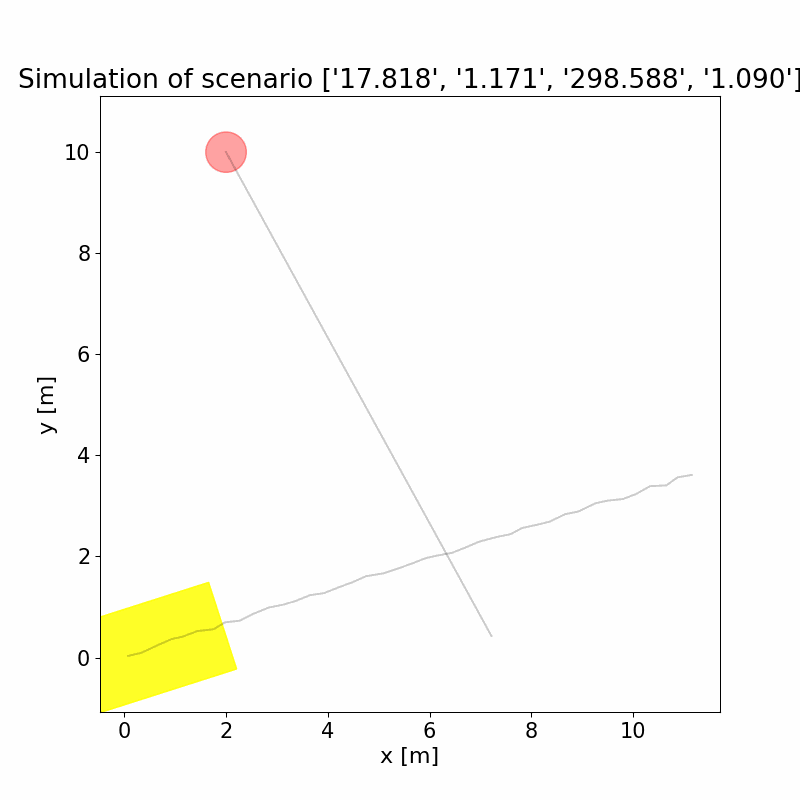

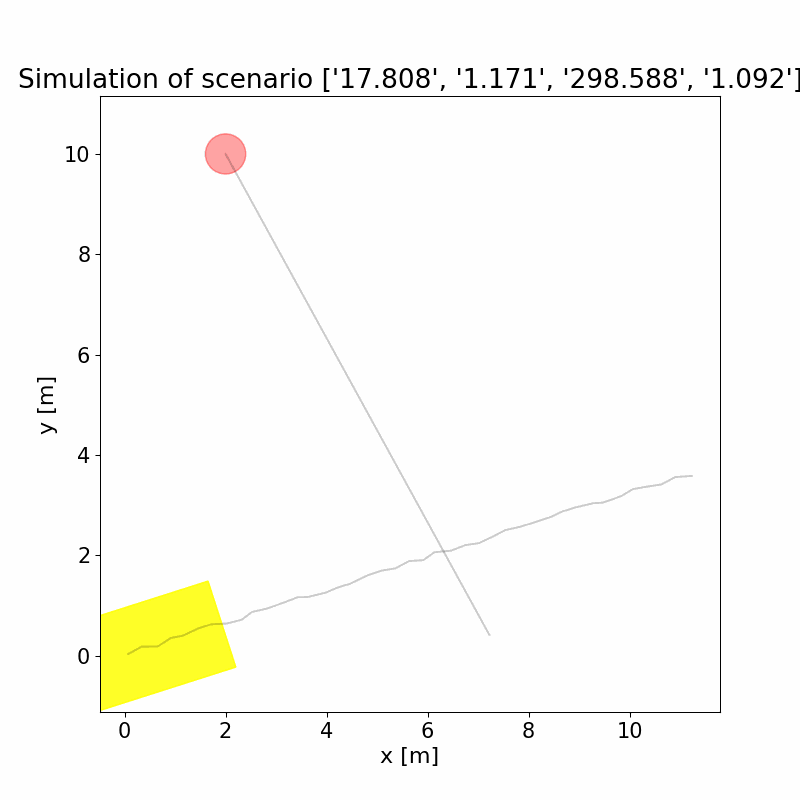

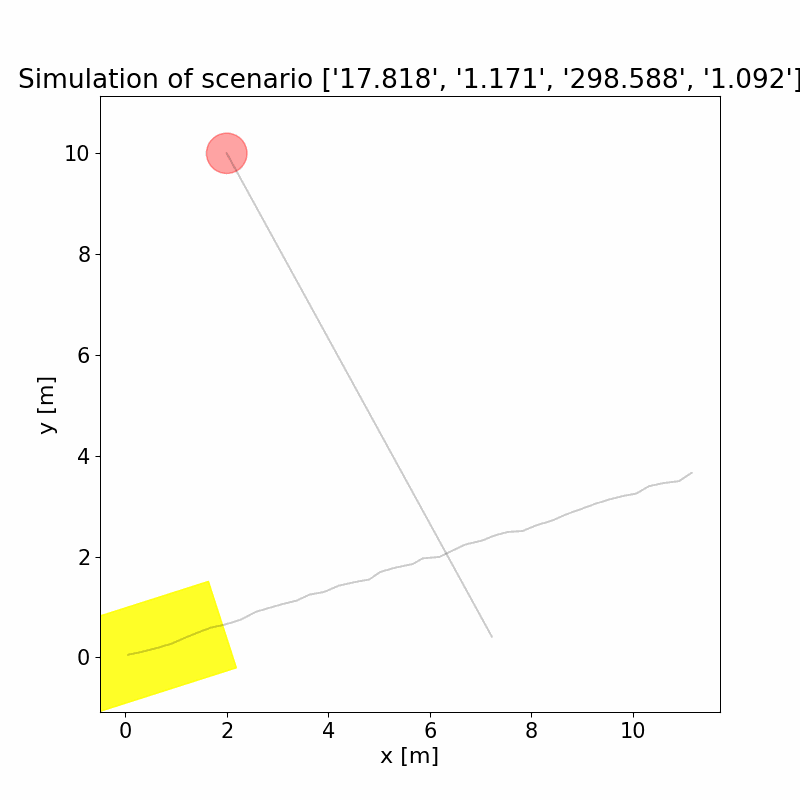

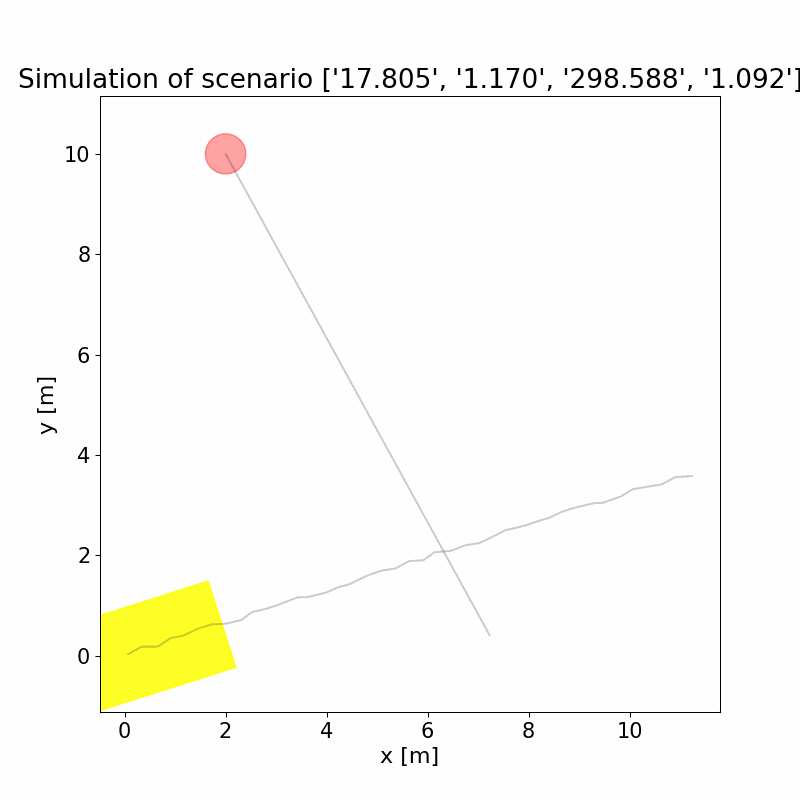

In [3]:
import pandas as pd
from pathlib import Path
import os

exp_folder = os.getcwd() + f"/results/DummySimulatorProblem/NSGA2/"
paths = sorted(Path(exp_folder).iterdir(), key=os.path.getmtime)
results_path = str(paths[-1])

df = pd.read_csv(f'{results_path}/all_critical_testcases.csv')

from IPython.display import Image
import os
n = 4 # show max n images
folder_gifs = results_path + os.sep + "gif"
i = 0
for f in os.listdir(folder_gifs):
    fpath = folder_gifs + os.sep + f
    if os.path.isfile(fpath) and i < n:
      img = Image(open(fpath,'rb').read(), width=300, height=300)
      display(img)
      i = i+1